# Medical Appointment No Show
What if it was possible someone to no-show an appointment?

Data from: https://www.kaggle.com/joniarroba/noshowappointments/home 

## Data Dictionary
PatientId - Identification of a patient AppointmentID - Identification of each appointment Gender = Male or Female . Female is the greater proportion, woman takes way more care of they health in comparison to man. DataMarcacaoConsulta = The day of the actuall appointment, when they have to visit the doctor. DataAgendamento = The day someone called or registered the appointment, this is before appointment of course. Age = How old is the patient. Neighbourhood = Where the appointment takes place. Scholarship = Ture of False . Observation, this is a broad topic, consider reading this article https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia Hipertension = True or False Diabetes = True or False Alcoholism = True or False Handcap = True or False SMS_received = 1 or more messages sent to the patient. No-show = True or False.

## Our Task
We will attempt to replicate results using **FastAI's** Deep Learning framework, building a **Deep Neural Network**

In [ ]:
# !pip install kaggle --upgrade
# !pip install fastai

In [372]:
from fastai.tabular import *
import torch
from torch.optim import *
import pandas as pd
import numpy as np
import os

In [118]:
# Making our directory, we already have Kaggle API set up. 
#The following assumes you have installed and setup Kaggle on your machine
!mkdir no_show_data
path = './no_show_data'

In [119]:
# downloading our data
!kaggle datasets download -d joniarroba/noshowappointments -f KaggleV2-May-2016.csv -p {path}

  0%|                                               | 0.00/2.08M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 2.08M/2.08M [00:00<00:00, 60.6MB/s]


In [120]:
os.listdir(path)

['KaggleV2-May-2016.csv.zip']

In [121]:
# unzipping our data and removing zipped file
!unzip ./no_show_data/KaggleV2-May-2016.csv.zip -d {path}

Archive:  ./no_show_data/KaggleV2-May-2016.csv.zip
  inflating: ./no_show_data/KaggleV2-May-2016.csv  


In [123]:
!rm -rf ./no_show_data/KaggleV2-May-2016.csv.zip
os.listdir(path)

['KaggleV2-May-2016.csv']

## Exploring Data
We will be utilizing **Pandas** along with **FastAI's** framework to both explore our data and prepare out data for the model

In [124]:
# Creating fastai Path object
path = Path(path)
path.ls()

[PosixPath('no_show_data/KaggleV2-May-2016.csv')]

In [125]:
# creating df
df = pd.read_csv('./no_show_data/KaggleV2-May-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


## Preparing Our Model
Now we will determine:
* dep_var - dependent variable / our target for predictions
* cat_names - continous variables / numerical data
* procs - Normalization to data

After we will create a **Data Object** utilizing **DataBlock API**

In [291]:
dep_var = 'No-show' # this should have been named 'label'
cat_names = ['Gender', 'AppointmentDay', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']
# cont_names = ['Age', 'PatientId', 'AppointmentID']
procs = [FillMissing, Categorify, Normalize]

In [407]:
seed = np.random.seed(42)

# data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
#                    .split_by_idx(list(range(60000,72000)))
#                    .label_from_df(cols=dep_var)
#                    .databunch(num_workers=2, bs=64))

data = (TabularList.from_df(df, path=path, cat_names=cat_names, procs=procs)
                   .random_split_by_pct(0.10, seed)
                   .label_from_df(cols=dep_var)
                   .databunch(num_workers=2, bs=256))

In [293]:
# You will notice this is very similar to pandas DF
data.show_batch(rows=5)

Gender,AppointmentDay,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,target
F,2016-05-24T00:00:00Z,FRADINHOS,0,0,0,0,0,0,No
F,2016-05-11T00:00:00Z,RESISTÊNCIA,0,0,0,0,0,1,No
F,2016-05-06T00:00:00Z,BONFIM,0,0,0,0,0,0,No
F,2016-05-19T00:00:00Z,SANTA TEREZA,0,0,0,0,0,0,No
F,2016-06-07T00:00:00Z,CENTRO,0,0,0,0,0,1,No


## First Model
We will first begin with a basic **3 layer** model and then experiment with **Regularization** methods
* Layers
* Layer size
* Dropout
* Weight Decay
* Momentum

In [127]:
for c in df.columns:
    print(f'{c}: {df[c].nunique()}')

PatientId: 62299
AppointmentID: 110527
Gender: 2
ScheduledDay: 103549
AppointmentDay: 27
Age: 104
Neighbourhood: 81
Scholarship: 2
Hipertension: 2
Diabetes: 2
Alcoholism: 2
Handcap: 5
SMS_received: 2
No-show: 2


In [414]:
arch = [200, 200, 50]
learn = tabular_learner(data, arch, metrics=[accuracy], emb_szs= {
    'Gender': 2, 
    'AppointmentDay': 27, 
    'Scholarship': 2,
    'Hipertension': 2,
    'Diabetes': 2,
    'Alcoholism': 2,
    'Handcap': 5,
    'SMS_received':2,
    'Neighbourhood': 81
})

In [415]:
learn.opt_func = torch.optim.Adam

In [402]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(28, 27)
    (2): Embedding(82, 81)
    (3): Embedding(3, 2)
    (4): Embedding(3, 2)
    (5): Embedding(3, 2)
    (6): Embedding(3, 2)
    (7): Embedding(6, 5)
    (8): Embedding(3, 2)
  )
  (emb_drop): Dropout(p=0.0)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=125, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): ReLU(inplace)
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=200, out_features=50, bias=True)
    (7): ReLU(inplace)
    (8): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=50, out_features=2, bias=True)
  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


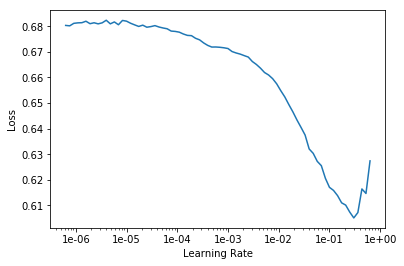

In [410]:
learn.lr_find()
learn.recorder.plot()

In [416]:
lr = 5e-2

In [417]:
learn.fit_one_cycle(100, slice(lr))

epoch,train_loss,valid_loss,accuracy
1,0.489246,0.488413,0.798769
2,0.493097,0.486450,0.798769
3,0.487711,0.486222,0.798769
4,0.492161,0.488180,0.798769
5,0.484853,0.487681,0.798769
6,0.489046,0.487103,0.798769
7,0.488585,0.486890,0.798860
8,0.483510,0.487104,0.798769
9,0.492946,0.485137,0.798950
10,0.487686,0.487416,0.798769


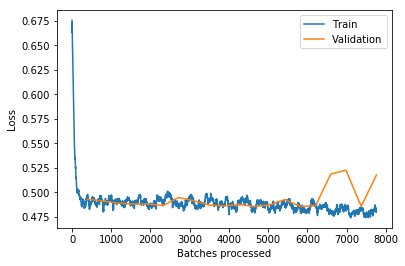

In [413]:
learn.recorder.plot_losses()